# Table of Content
- [Aims](#Aims)
- [Helper Functions](#Helper-Functions)
- [Import Data](#Import-Data)
- [Exploratory Data Analysis](#Exploratory-Data-Analysis)
- [Data Splitting](#Data-Splitting)
- [Models](#Models)
- [ANOVA](#ANOVA)
- [Stepwise Regression](#Stepwise-Regression)
- [Model Evaluation](#Model-Evaluation)
- [Conclusion](#Conclusion)
- [Problems](#Problems)
- [Further Work](#Further-Work)

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import seaborn as sns
from IPython.display import display
import statsmodels.api as sm

from scipy import stats
from statsmodels.stats.outliers_influence import OLSInfluence
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.graphics.gofplots import ProbPlot
from statsmodels.stats.diagnostic import het_goldfeldquandt
from statsmodels.stats.stattools import durbin_watson

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
from sklearn.base import BaseEstimator

import itertools

# import warnings
# warnings.filterwarnings('ignore')

# Aims

https://www.kaggle.com/datasets/neuromusic/avocado-prices

#### Construct a regression model to interpret how variables affect the average price.

# Helper Functions

#### 1. Helper function for creating dummy variables and interaction effects.

In [2]:
def make_dummies(df, categories = {}, interactions = []):
    for col, category in categories.items():
        df2 = pd.get_dummies(df[col])[category]
        df = pd.concat([df, df2], axis = 1).drop(col, axis = 1)
    for cols in interactions:
        lists = [categories[col] for col in cols]
        combins = list(itertools.product(*lists))
        for combin in combins:
            df['_'.join(combin)] = df[list(combin)].product(axis = 1)
    return df

#### 2. Helper function for performing Goldfeld Quandt Test as there are many interaction effects and only perform the test for between the groups with maximum and minimum variance.

In [3]:
def goldfeld_quandt(endog, exog, gp):
    df = pd.DataFrame(endog, columns = ['endog'])
    df = pd.concat([df, exog], axis = 1)
    variance = df.groupby(gp)['endog'].std().sort_values()**2
    max_exog = variance.index[-1]
    min_exog = variance.index[0]
    df = df.set_index(gp).sort_index()
    df1 = df.loc[max_exog]
    df2 = df.loc[min_exog]
    index = len(df2)
    df = pd.concat([df2, df1], ignore_index = True)
    return het_goldfeldquandt(df['endog'], sm.add_constant(df[exog.columns.drop(gp)]), split = index)

#### 3. Helper function for performing Breusch Godfrey Test as there are multiple data in one time frame. The function provided by statsmodels cannot deal with this case.

In [4]:
def breusch_godfrey(resid, date, exog = None, gp = None, nlags = 1):
    '''
    Assume e_t = alpha_1*e_t-1+nu_t
    '''
    dfs = []
    if exog is not None:
        dfs.append(exog)
    if gp is not None:
        dfs.append(gp)
    if len(dfs) > 0:
        df = pd.concat([resid, date] + dfs, axis = 1)
    else:
        df = pd.concat([resid, date], axis = 1, ignore_index=True)
        
    if gp is None:
        df = df.sort_values(date.name)
    else:
        df = df.sort_values([gp.name, date.name])
        
    if exog is None:
        cols = []
    elif isinstance(exog, pd.Series):
        cols = [exog.name]
    else:
        cols = exog.columns.tolist()
        
    for i in range(1, nlags+1):
        if gp is None:
            df[resid.name + f'_lag_{i}'] = df[resid.name].shift(i)
        else:
            df[resid.name + f'_lag_{i}'] = df.groupby(gp.name)[resid.name].shift(i)
        cols.append(resid.name + f'_lag_{i}')
        
    df = df.dropna()
    model = sm.OLS(df[resid.name], sm.add_constant(df[cols])).fit()
    lm = len(df) * model.rsquared
    lmpval = stats.chi2.sf(lm, nlags)
    return (lm, lmpval)

#### 4. Helper function for performing model diagnosis (applicable for both OLS and GLM)

In [5]:
def Model_Diagnostic(model, date, gp = None):
    
    print('='*50, "Model Diagnosis", '='*50)
    
    model_fitted_y = model.fittedvalues
    if isinstance(model.model, sm.OLS):
        standardized_residuals = model.get_influence().resid_studentized_internal
    elif isinstance(model.model, sm.GLM):
        standardized_residuals = model.resid_deviance / np.sqrt(model.scale)
#     standardized_residuals = model.resid_pearson
    
    data_time = pd.DataFrame({'Residual': standardized_residuals,
                              'Date': date})
    data_time = data_time.reset_index(drop = True)
    exog = pd.DataFrame(model.model.exog, columns = model.model.exog_names)
    if 'const' in exog.columns:
        exog = exog.drop(columns = 'const')
    data_time = pd.concat([data_time, exog], axis = 1)
    data_time = data_time.sort_values('Date')
    
    fig, axes = plt.subplots(2, 2, figsize = (10, 10))
    axes = axes.flatten()
    
    axes[0].hist(standardized_residuals)
    
    stats.probplot(standardized_residuals, dist="norm", plot = axes[1])
    
    if isinstance(model.model, sm.OLS):
        df = pd.DataFrame({'x': model_fitted_y,
                           'y': standardized_residuals})
    else:
        df = pd.DataFrame({'x': model.predict(model.model.exog, linear = True),
                           'y': standardized_residuals})
    sns.residplot(x = 'x', y = 'y', data = df,
                  lowess=True,
                  scatter_kws={'alpha': 0.5},
                  line_kws={'color': 'red', 'lw': 1, 'alpha': 0.8}, ax = axes[2])
    
    sns.lineplot(data = data_time, x = 'Date', y = 'Residual', ax = axes[3])
    
    plt.show()
    
    print('='*50, "Test for Normality", '='*50)
    df = {'test statistic': [],
          'p-value': []}
    result = stats.jarque_bera(standardized_residuals)
    df['test statistic'].append(result[0])
    df['p-value'].append(result[1])
    result = stats.kstest(standardized_residuals, stats.norm.cdf)
    df['test statistic'].append(result[0])
    df['p-value'].append(result[1])
    result = stats.shapiro(standardized_residuals)
    df['test statistic'].append(result[0])
    df['p-value'].append(result[1])
    df = pd.DataFrame(df, index = ['Jarque-Bera', 'Kolmogorov-Smirnov', 'Shapiro-Wilk'])
    display(df)
    print()
    
    if isinstance(model.model, sm.OLS):
        print('='*50, 'Test for Homoscedasticity', '='*50)
        if gp is not None:
            result = goldfeld_quandt(model.model.endog, exog, gp)
            df = pd.DataFrame({'test statistic': [result[0]],
                               'p-value': [result[1]]}, index = ['Goldfeld-Quandt'])
            display(df)
        print()
    
    print('='*40, 'Test for First Order AutoCorrelation', '='*40)
    if gp is None:
        result = durbin_watson(data_time['Residual'])
        df = pd.DataFrame({'test statistic': [result]}, index = ['Durbin-Watson'])
    else:
        data_time['Id'] = 1
        data_time['Id'] = data_time.groupby('Date')['Id'].cumsum()
        
        result = breusch_godfrey(data_time['Residual'], data_time['Date'], data_time[exog.columns], data_time['Id'])
        df = pd.DataFrame({'test statistic': [result[0]],
                           'p-value': [result[1]]}, index = ['Breusch-Godfrey'])
    
    display(df)

#### 5. Helper function for computing the scale of GLM with Gamma Distribution by MLE, which is less bias then that computed by Method of Moment which is used in statsmodels.

In [6]:
def Gamma_Shape(model, y, max_iter = 10, max_eps = 1e-4):
    
    from scipy.special import polygamma
    
    prior_weights = np.ones(len(y))
    fitted_value = model.fittedvalues
    Dbar = model.deviance / model.df_resid
    alpha = (6+2*Dbar)/(Dbar*(6+Dbar))
    
    fixed = -y/fitted_value - np.log(fitted_value) + np.log(prior_weights) + 1 + np.log(y + (y==0)*1)
    eps = 1
    itr = 0
    
    
    while ((np.abs(eps) > max_eps) & (itr < max_iter)):
        sc = np.sum(prior_weights * (fixed + np.log(alpha) - polygamma(0, prior_weights * alpha)))
        inf = np.sum(prior_weights * (prior_weights * polygamma(1, prior_weights*alpha) - 1 / alpha))
        eps = sc / inf
        alpha += eps
        
        itr += 1
    return (alpha, np.sqrt(1/inf))
# Converted from https://github.com/cran/MASS/blob/master/R/gamma.shape.R

#### 6. Helper function for performing hypothesis testing (applicable for both OLS and GLM) on significance of a group of variables.

In [7]:
def Hypothesis_Testing(model, y, full_exog, reduced_exog):
    if isinstance(model.model, sm.OLS):
        full_model = sm.OLS(y, sm.add_constant(full_exog)).fit()
        reduced_model = sm.OLS(y, sm.add_constant(reduced_exog)).fit()
    elif isinstance(model.model, sm.GLM):
        full_model = sm.GLM(y, sm.add_constant(full_exog), family = model.family).fit()
        reduced_model = sm.GLM(y, sm.add_constant(reduced_exog), family = model.family).fit()
        full_deviance = full_model.deviance
        reduced_deviance = reduced_model.deviance
        full_scale = full_model.scale
        reduced_scale = reduced_model.scale
        if isinstance(model.family, sm.families.Gamma):
            full_scale = Gamma_Shape(full_model, y)[0]
            full_scale = 1/full_scale
            reduced_scale = Gamma_Shape(reduced_model, y)[0]
            reduced_scale = 1/reduced_scale
        full_deviance = full_deviance/full_scale
        reduced_deviance = reduced_deviance/reduced_scale
        df = reduced_model.df_resid - full_model.df_resid
        test_statistic = reduced_deviance - full_deviance
        p_value = stats.chi.sf(test_statistic, df)
        result = pd.DataFrame({'test statistic': [test_statistic],
                               'p-value': [p_value]}, index = ['Likelihood Ratio Test'])
        return result

#### 7. Helper function for performing stepwise regression (applicable for both OLS and GLM) for feature selection

In [8]:
def Stepwise_Regression(model, y, X, alpha_in = 0.05, alpha_out = 0.10, verbose = True):
    remaining_list = X.columns.tolist().copy()
    selected_list = []
    selected = None
    removed = None
    p_value_in = None
    p_value_out = None
    
    if verbose:
        display_df = {'Variable Entered': [],
                      'Variable Removed': [],
                      'Test Statistic': [],
                      'p-value': []}
      
    while len(remaining_list) != 0:
        test_statistic = 0
        p_value = 1
        for col in remaining_list:
            cols = selected_list.copy()
            cols.append(col)
            
            result = Hypothesis_Testing(model, y, X[cols], X[selected_list])
            if result.loc['Likelihood Ratio Test', 'test statistic'] > test_statistic:
                selected = col
                test_statistic = result.loc['Likelihood Ratio Test', 'test statistic']
                p_value = result.loc['Likelihood Ratio Test', 'p-value']
                
        if p_value < alpha_in:
            selected_list.append(selected)
            remaining_list.remove(selected)
            
            if verbose:
                display_df['Variable Entered'].append(selected)
                display_df['Variable Removed'].append(None)
                display_df['Test Statistic'].append(test_statistic)
                display_df['p-value'].append(p_value)
                
        else:
            if verbose:
                display_df = pd.DataFrame(display_df)
                display(display_df)
            return selected_list
        
        test_statistic = np.inf
        for col in selected_list:
            cols = selected_list.copy()
            cols.remove(col)
            
            result = Hypothesis_Testing(model, y, X[selected_list], X[cols])
            
            if result.loc['Likelihood Ratio Test', 'test statistic'] < test_statistic:
                removed = col
                test_statistic = result.loc['Likelihood Ratio Test', 'test statistic']
                p_value = result.loc['Likelihood Ratio Test', 'p-value']        
        
        if p_value >= alpha_out:
            selected_list.remove(removed)
            
            if verbose:
                display_df['Variable Entered'].append(None)
                display_df['Variable Removed'].append(removed)
                display_df['Test Statistic'].append(test_statistic)
                display_df['p-value'].append(p_value)

#### This class is to extend the GLM class in statsmodels so that cross validation function in sklearn can also apply on this module.

In [9]:
class GLM(BaseEstimator):
    def __init__(self, family = 'gaussian', link = 'identity', fit_intercept = True):
        self.family = family
        self.link = link
        self.fit_intercept = fit_intercept
        
    def fit(self, X, y):
        X_copy = X.copy()
        
        if self.fit_intercept:
            X_copy = sm.add_constant(X)
        
        if self.link == 'identity':
            link = None
        elif self.link == 'log':
            link = sm.families.links.log()
        else:
            assert False, "Unsupported Link Function"
        
        if self.family == 'gaussian':
            family = sm.families.Gaussian(link = link)
        elif self.family == 'Binomial':
            family = sm.families.Binomial(link = link)
        elif self.family == 'Gamma':
            family = sm.families.Gamma(link = link)
        else:
            assert False, "Unsupported Family Distribution"
        
        model = sm.GLM(y, X_copy, family = family).fit()
        if self.family == 'Gamma':
            scale = 1/(Gamma_Shape(model, y)[0])
            model = sm.GLM(y, X_copy, family = family).fit(scale = scale)
            
        self.coef_ = model.params.drop('const').to_numpy()
        if self.fit_intercept:
            self.intercept_ = model.params['const']
        else:
            self.intercept_ = 0
        return self
    
    def predict(self, X):
        if isinstance(X, pd.Series) or isinstance(X, pd.DataFrame):
            X_copy = X.to_numpy()
        elif isinstance(X, list):
            X_copy = np.array(X)
        else:
            X_copy = X
            
        p = X_copy @ self.coef_ + self.intercept_
        if self.link == 'log':
            p = np.exp(p)
        return p

# Import Data

In [10]:
data = pd.read_csv('../../data/Avocado/avocado.csv', index_col = 0)
data.shape

(18249, 13)

In [11]:
data.head()

,Date,AveragePrice,Total Volume,4046,4225,4770,Total Bags,Small Bags,Large Bags,XLarge Bags,type,year,region
0,2015-12-27,1.33,64236.62,1036.74,54454.85,48.16,8696.87,8603.62,93.25,0.0,conventional,2015,Albany
1,2015-12-20,1.35,54876.98,674.28,44638.81,58.33,9505.56,9408.07,97.49,0.0,conventional,2015,Albany
2,2015-12-13,0.93,118220.22,794.70,109149.67,130.50,8145.35,8042.21,103.14,0.0,conventional,2015,Albany
3,2015-12-06,1.08,78992.15,1132.00,71976.41,72.58,5811.16,5677.40,133.76,0.0,conventional,2015,Albany
4,2015-11-29,1.28,51039.60,941.48,43838.39,75.78,6183.95,5986.26,197.69,0.0,conventional,2015,Albany


In [12]:
data['Date'] = pd.to_datetime(data['Date'])

In [13]:
data['season'] = ['Spring' if (x == 3 or x == 4 or x == 5) else
                  'Summer' if (x == 6 or x == 7 or x == 8) else
                  'Autumn' if (x == 9 or x == 10 or x == 11) else
                  'Winter' for x in data['Date'].dt.month]

# Exploratory Data Analysis

In [14]:
data['Date'].value_counts().tail()

2016-11-06    108
2018-01-07    108
2017-06-18    107
2017-06-25    107
2015-12-06    107
Name: Date, dtype: int64

In [15]:
data[(data['Date'].isin(['2015-12-06', '2017-06-18', '2017-06-25'])) & (data['region'] == 'WestTexNewMexico')]

,Date,AveragePrice,Total Volume,4046,4225,4770,Total Bags,Small Bags,Large Bags,XLarge Bags,type,year,region,season
3,2015-12-06,0.74,623231.77,398871.12,133434.18,21088.12,69838.35,68233.56,1604.79,0.00,conventional,2015,WestTexNewMexico,Winter
27,2017-06-25,0.85,1022130.10,565529.68,82613.84,8881.62,365104.96,150840.39,214264.57,0.00,conventional,2017,WestTexNewMexico,Summer
28,2017-06-18,0.87,1046946.87,578248.12,88224.45,10539.38,369934.92,164735.40,205157.85,41.67,conventional,2017,WestTexNewMexico,Summer


#### In these 3 days, data of organic avocado sold in WestTexNewMexico are missing.

In [16]:
data.describe()

,AveragePrice,Total Volume,4046,4225,4770,Total Bags,Small Bags,Large Bags,XLarge Bags,year
count,18249.000000,1.824900e+04,1.824900e+04,1.824900e+04,1.824900e+04,1.824900e+04,1.824900e+04,1.824900e+04,18249.000000,18249.000000
mean,1.405978,8.506440e+05,2.930084e+05,2.951546e+05,2.283974e+04,2.396392e+05,1.821947e+05,5.433809e+04,3106.426507,2016.147899
std,0.402677,3.453545e+06,1.264989e+06,1.204120e+06,1.074641e+05,9.862424e+05,7.461785e+05,2.439660e+05,17692.894652,0.939938
min,0.440000,8.456000e+01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,2015.000000
25%,1.100000,1.083858e+04,8.540700e+02,3.008780e+03,0.000000e+00,5.088640e+03,2.849420e+03,1.274700e+02,0.000000,2015.000000
50%,1.370000,1.073768e+05,8.645300e+03,2.906102e+04,1.849900e+02,3.974383e+04,2.636282e+04,2.647710e+03,0.000000,2016.000000
75%,1.660000,4.329623e+05,1.110202e+05,1.502069e+05,6.243420e+03,1.107834e+05,8.333767e+04,2.202925e+04,132.500000,2017.000000
max,3.250000,6.250565e+07,2.274362e+07,2.047057e+07,2.546439e+06,1.937313e+07,1.338459e+07,5.719097e+06,551693.650000,2018.000000


In [17]:
model = sm.OLS(data['Total Volume'], data[['4046', '4225', '4770']]).fit()
model.rsquared

0.9898550050300592

#### There are other types of avocadoes sold in US but not recorded in the dataset, but the majority of the volume is from these 3 types.
https://californiaavocado.com/retail/avocado-plus/#:~:text=PLU%20numbers%20are%20used%20to,the%20regular%20four%2Ddigit%20code.

In [18]:
model = sm.OLS(data['Total Bags'], data[['Small Bags', 'Large Bags', 'XLarge Bags']]).fit()
model.rsquared

0.999999999999996

#### Total number of bags is the sum of those of small, large and xlarge bags.

In [19]:
data.corr(numeric_only = True)

,AveragePrice,Total Volume,4046,4225,4770,Total Bags,Small Bags,Large Bags,XLarge Bags,year
AveragePrice,1.000000,-0.192752,-0.208317,-0.172928,-0.179446,-0.177088,-0.174730,-0.172940,-0.117592,0.093197
Total Volume,-0.192752,1.000000,0.977863,0.974181,0.872202,0.963047,0.967238,0.880640,0.747157,0.017193
4046,-0.208317,0.977863,1.000000,0.926110,0.833389,0.920057,0.925280,0.838645,0.699377,0.003353
4225,-0.172928,0.974181,0.926110,1.000000,0.887855,0.905787,0.916031,0.810015,0.688809,-0.009559
4770,-0.179446,0.872202,0.833389,0.887855,1.000000,0.792314,0.802733,0.698471,0.679861,-0.036531
Total Bags,-0.177088,0.963047,0.920057,0.905787,0.792314,1.000000,0.994335,0.943009,0.804233,0.071552
Small Bags,-0.174730,0.967238,0.925280,0.916031,0.802733,0.994335,1.000000,0.902589,0.806845,0.063915
Large Bags,-0.172940,0.880640,0.838645,0.810015,0.698471,0.943009,0.902589,1.000000,0.710858,0.087891
XLarge Bags,-0.117592,0.747157,0.699377,0.688809,0.679861,0.804233,0.806845,0.710858,1.000000,0.081033
year,0.093197,0.017193,0.003353,-0.009559,-0.036531,0.071552,0.063915,0.087891,0.081033,1.000000


#### Volume and number of bags do not directly cause the change on the price of avocado, and their correlation to the price is low. Therefore, these factors are excluded from modeling.

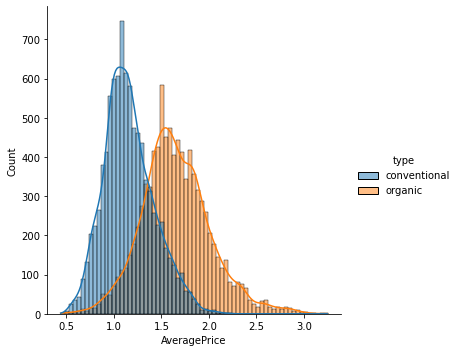

In [20]:
sns.displot(data = data, x = 'AveragePrice', hue = 'type', kde = True)
plt.show()

#### Organic avocado is averagly higher in price.

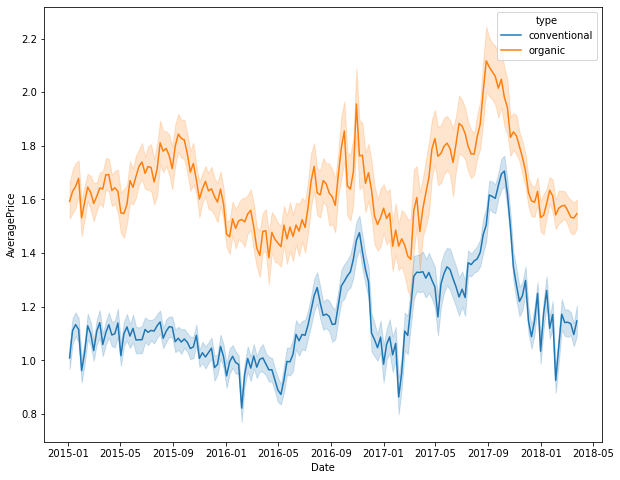

In [21]:
plt.figure(figsize = (10, 8))
sns.lineplot(data = data, x = 'Date', y = 'AveragePrice', hue = 'type')
plt.show()

#### Avocado price is higher in Summer and Autumn.

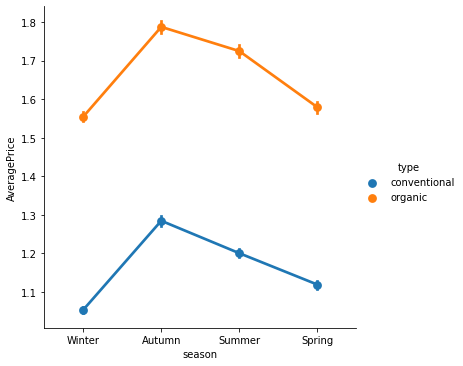

In [22]:
sns.catplot(data = data, x = 'season', y = 'AveragePrice', hue = 'type', kind = 'point')
plt.show()

#### No interaction between type and season as the lines are parallel.

In [23]:
len(np.unique(data['region']))

54

In [24]:
data['region'].value_counts()

Albany                 338
Sacramento             338
Northeast              338
NorthernNewEngland     338
Orlando                338
Philadelphia           338
PhoenixTucson          338
Pittsburgh             338
Plains                 338
Portland               338
RaleighGreensboro      338
RichmondNorfolk        338
Roanoke                338
SanDiego               338
Atlanta                338
SanFrancisco           338
Seattle                338
SouthCarolina          338
SouthCentral           338
Southeast              338
Spokane                338
StLouis                338
Syracuse               338
Tampa                  338
TotalUS                338
West                   338
NewYork                338
NewOrleansMobile       338
Nashville              338
Midsouth               338
BaltimoreWashington    338
Boise                  338
Boston                 338
BuffaloRochester       338
California             338
Charlotte              338
Chicago                338
C

In [25]:
data['year'].value_counts()

2017    5722
2016    5616
2015    5615
2018    1296
Name: year, dtype: int64

# Data Splitting

In [26]:
train = data[data['Date'] <= '2017-03-31']
test = data[data['Date'] >= '2017-04-01']

print(f'The proportion of training data is: {train.shape[0]/len(data)*100:.0f}%')
print(f'The proportion of testing data is: {test.shape[0]/len(data)*100:.0f}%')

The proportion of training data is: 69%
The proportion of testing data is: 31%


#### A yearly data from Apr-2017 to Mar-2018 is splitted as testing data. The other is the training data. The ratio is around 7:3.

# Models 

In [27]:
dummy_dict = {'type': ['organic'],
              'region': [x for x in train['region'].unique() if x != 'HarrisburgScranton'],
              'season': ['Spring', 'Summer', 'Autumn']}
interaction_list = [('type', 'region'), ('type', 'season'), ('region', 'season'),
                    ('type', 'region', 'season')]

- Conventional Avocado sold in Harrisburg Scranton in winter is set as reference group.  
- The intercept of regression model is the estimates of the price of the reference group.  
- The other coefficients represent the effect of the presence of the other groups on the price.

In [28]:
train = train.sort_values(['Date', 'region', 'type'])

## Model 1

In [29]:
X = make_dummies(train[['type', 'region', 'season', 'year']], categories = dummy_dict, interactions= interaction_list)
y = train['AveragePrice']

In [30]:
X.head()

,year,organic,Albany,Atlanta,BaltimoreWashington,Boise,Boston,BuffaloRochester,California,Charlotte,...,organic_Tampa_Autumn,organic_TotalUS_Spring,organic_TotalUS_Summer,organic_TotalUS_Autumn,organic_West_Spring,organic_West_Summer,organic_West_Autumn,organic_WestTexNewMexico_Spring,organic_WestTexNewMexico_Summer,organic_WestTexNewMexico_Autumn
51,2015,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
51,2015,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
51,2015,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
51,2015,1,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
51,2015,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


#### The number of factors should be:
- 1 (type)+
- 53 (region)+
- 3 (season)+
- 1 (year)+
- 1\*53 (type\*region)+
- 1\*3 (type\*season)+
- 53\*3 (region\*season)+
- 1\*53\*3 (type\*region\*season)

In [31]:
print(f'Is number of factors as expected? {1+53+3+1+1*53+1*3+53*3+1*53*3 == X.shape[1]}')

Is number of factors as expected? True


In [32]:
model_1 = sm.OLS(y, sm.add_constant(X)).fit()
# model_1.summary()

================================================== Model Diagnosis ==================================================


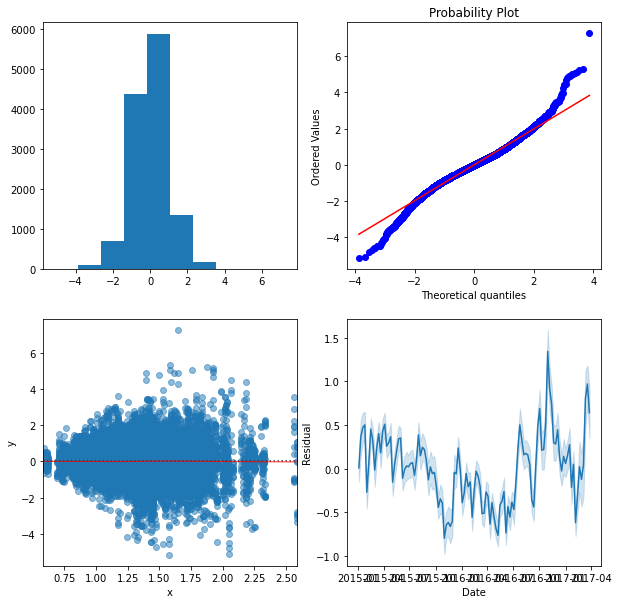

================================================== Test for Normality ==================================================


C:\Users\abddd\anaconda3\lib\site-packages\scipy\stats\morestats.py:1681: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


,test statistic,p-value
Jarque-Bera,2408.113952,0.000000e+00
Kolmogorov-Smirnov,0.040776,1.085096e-18
Shapiro-Wilk,0.980195,2.069996e-38



================================================== Test for Homoscedasticity ==================================================


,test statistic,p-value
Goldfeld-Quandt,3038.444444,1.454434e-12



======================================== Test for First Order AutoCorrelation ========================================


,test statistic,p-value
Breusch-Godfrey,1130.698613,7.027475e-248


In [33]:
Model_Diagnostic(model = model_1, date = train['Date'], gp = X.columns.tolist())

- Curved and increasing variance => Violation on homoscedasticity
- A bit left-skewed in Q-Q plot => Violation on normality
- Negative autocorrelated => Violation on indepedence

## Model 2

#### As the price is always greater than or equal to 0, assuming normal distribution which ranges from $-\infty$ to $\infty$ is not appropriate. Therefore, we take log transformation on the price.

In [34]:
y = train['AveragePrice']
y = np.log(y)
y = y.rename('log_AveragePrice')

In [35]:
model_2 = sm.OLS(y, sm.add_constant(X)).fit()
# model_2.summary()

================================================== Model Diagnosis ==================================================


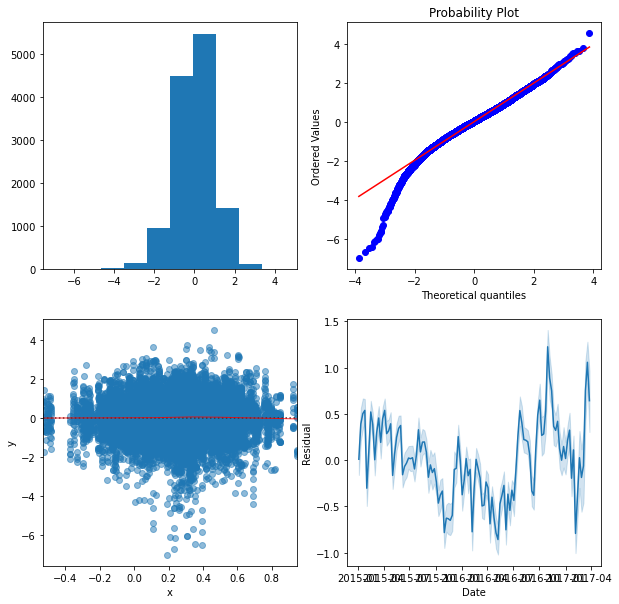

================================================== Test for Normality ==================================================


C:\Users\abddd\anaconda3\lib\site-packages\scipy\stats\morestats.py:1681: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


,test statistic,p-value
Jarque-Bera,4034.816017,0.000000e+00
Kolmogorov-Smirnov,0.037081,1.570969e-15
Shapiro-Wilk,0.976144,2.727627e-41



================================================== Test for Homoscedasticity ==================================================


,test statistic,p-value
Goldfeld-Quandt,6031.199231,0.000003



======================================== Test for First Order AutoCorrelation ========================================


,test statistic,p-value
Breusch-Godfrey,1069.180437,1.649785e-234


In [36]:
Model_Diagnostic(model = model_2, date = train['Date'], gp = X.columns.tolist())

In [37]:
SSE = np.sum((np.exp(y) - np.exp(model_2.fittedvalues))**2)
SST = np.sum((np.exp(y) - np.mean(np.exp(y)))**2)
1-(SSE/(X.shape[0] - X.shape[1] - 1))/(SST/(X.shape[0] - 1))

0.7410136189286729

#### Although model 1 has a higher adjusted r-squared, the residual plot shows less fan-shape which means the violation on homoscedascity is less serious.

## Model 3

#### Gamma Distribution is also ranges from 0 to $\infty$ which fits the domain of the price.

In [38]:
y = train['AveragePrice']

In [39]:
model_3 = sm.GLM(y, sm.add_constant(X), family = sm.families.Gamma(link = sm.families.links.log())).fit()

In [40]:
dispersion = Gamma_Shape(model_3, y)[0]
dispersion = 1/dispersion
dispersion

0.020267589784971965

In [41]:
model_3 = sm.GLM(y, sm.add_constant(X), family = sm.families.Gamma(link = sm.families.links.log())).fit(scale = dispersion)
# model_3.summary()

In [42]:
print('Lack of fit:', model_3.deviance/(model_3.scale*(X.shape[0] - X.shape[1] - 1)))

Lack of fit: 1.038983643114171


#### A simple rule of thumb: if the ratio is $\approx$ 1, there is no lack of fit.

================================================== Model Diagnosis ==================================================


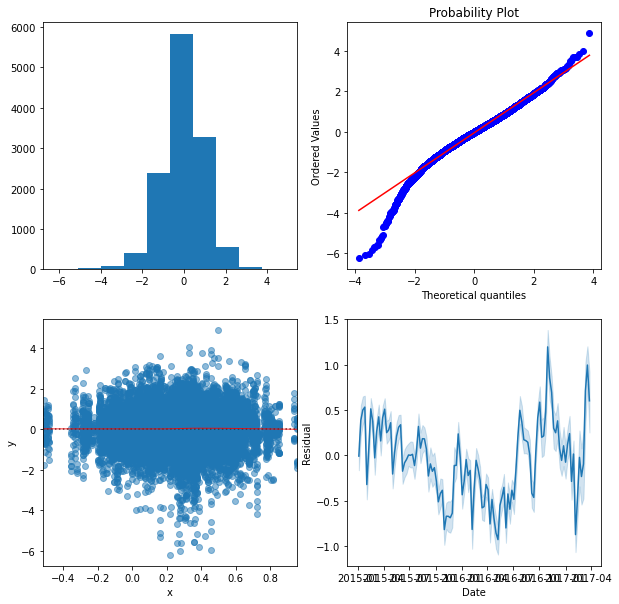

================================================== Test for Normality ==================================================


C:\Users\abddd\anaconda3\lib\site-packages\scipy\stats\morestats.py:1681: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


,test statistic,p-value
Jarque-Bera,2510.516418,0.000000e+00
Kolmogorov-Smirnov,0.036103,9.591250e-15
Shapiro-Wilk,0.981424,1.916581e-37



======================================== Test for First Order AutoCorrelation ========================================


,test statistic,p-value
Breusch-Godfrey,1120.305335,1.275477e-245


In [43]:
Model_Diagnostic(model = model_3, date = train['Date'], gp = X.columns.tolist())

In [44]:
SSE = np.sum((y - model_3.fittedvalues)**2)
SST = np.sum((y - np.mean(y))**2)
1-(SSE/(X.shape[0] - X.shape[1] - 1))/(SST/(X.shape[0] - 1))

0.7436655972640875

#### The residual plots of model 3 is similar to model 2, but with higher adjusted r-squared. Therefore, model 3 is selected.

# ANOVA

#### The model is too complex as there are two-way (e.g. type\*region) and three-way (year\*\region\*season) interaction effects considered. In the following, we would like to test if these interaction effects are significant hierarchically.

In [45]:
X = make_dummies(train[['year', 'type', 'region', 'season']], categories = dummy_dict, interactions= interaction_list)
y = train['AveragePrice']

## Linear Combination of 3 Way Interaction

In [46]:
reduced_3_way = [x for x in X.columns if len(x.split('_')) == 3]
len(reduced_3_way)

159

In [47]:
print(f'Is number of factors removed as expected? {1*53*3 == len(reduced_3_way)}')

Is number of factors removed as expected? True


In [48]:
Hypothesis_Testing(model_3, y, X, X.drop(columns = reduced_3_way))

,test statistic,p-value
Likelihood Ratio Test,1.688907,1.0


## Linear Combination of Interaction

In [49]:
reduced_2_way = [x for x in X.columns if len(x.split('_')) >= 2]
len(reduced_2_way)

374

In [50]:
print(f'Is number of factors removed as expected? {1*53+1*3+53*3+1*53*3 == len(reduced_2_way)}')

Is number of factors removed as expected? True


In [51]:
Hypothesis_Testing(model_3, y, X.drop(columns = reduced_3_way), X.drop(columns = reduced_2_way))

,test statistic,p-value
Likelihood Ratio Test,11.1023,1.0


## BIC

In [52]:
three_way_model = model_3

two_way_model = sm.GLM(y, sm.add_constant(X.drop(columns = reduced_3_way)), family = sm.families.Gamma(link = sm.families.links.log())).fit()
scale = 1/Gamma_Shape(two_way_model, y)[0]
two_way_model = sm.GLM(y, sm.add_constant(X.drop(columns = reduced_3_way)), family = sm.families.Gamma(link = sm.families.links.log())).fit(scale = scale)

main_effect_model = sm.GLM(y, sm.add_constant(X.drop(columns = reduced_2_way)), family = sm.families.Gamma(link = sm.families.links.log())).fit()
scale = 1/Gamma_Shape(main_effect_model, y)[0]
main_effect_model = sm.GLM(y, sm.add_constant(X.drop(columns = reduced_2_way)), family = sm.families.Gamma(link = sm.families.links.log())).fit(scale = scale)

In [53]:
print('With 3 way interaction effect:', three_way_model.bic)
print('With 2 way interaction effect:', two_way_model.bic)
print('With main effect only:', main_effect_model.bic)

With 3 way interaction effect: -114981.49990836551
With 2 way interaction effect: -116472.9272890187
With main effect only: -118436.28439450335


C:\Users\abddd\AppData\Roaming\Python\Python39\site-packages\statsmodels\genmod\generalized_linear_model.py:1799: FutureWarning: The bic value is computed using the deviance formula. After 0.13 this will change to the log-likelihood based formula. This change has no impact on the relative rank of models compared using BIC. You can directly access the log-likelihood version using the `bic_llf` attribute. You can suppress this message by calling statsmodels.genmod.generalized_linear_model.SET_USE_BIC_LLF with True to get the LLF-based version now or False to retainthe deviance version.
  warnings.warn(


## 5-Fold CV MSE

In [54]:
glm = GLM()
print('With 3 way interaction effect:', -np.mean(cross_val_score(glm, X, y, scoring = 'neg_mean_squared_error', cv = 5)))
print('With 2 way interaction effect:', -np.mean(cross_val_score(glm, X.drop(columns = reduced_3_way), y, scoring = 'neg_mean_squared_error', cv = 5)))
print('With main effect only:', -np.mean(cross_val_score(glm, X.drop(columns = reduced_2_way), y, scoring = 'neg_mean_squared_error', cv = 5)))

With 3 way interaction effect: 0.06550598891575779
With 2 way interaction effect: 0.06425528817236595
With main effect only: 0.06337489570728076


#### In presective of BIC, 5-Fold CV MSE and parsimony, the model with only main effects is the best. It suggests dropping the interaction effects.

# Final Model

In [55]:
X = make_dummies(data[['year', 'type', 'region', 'season']], categories = dummy_dict, interactions= interaction_list)
y = data['AveragePrice']

In [56]:
stepwise_list = Stepwise_Regression(model_3, y, X.drop(columns = reduced_2_way))

,Variable Entered,Variable Removed,Test Statistic,p-value
0,organic,None,93.930915,0.000000e+00
1,Autumn,None,7.780036,7.216450e-15
2,Summer,None,4.754598,1.988418e-06
3,Houston,None,4.653050,3.270611e-06
4,year,None,4.532153,5.838548e-06
5,DallasFtWorth,None,3.818549,1.342390e-04
6,HartfordSpringfield,None,3.610004,3.061925e-04
7,SouthCentral,None,3.370224,7.510718e-04
8,SanFrancisco,None,3.237292,1.206701e-03
9,NewYork,None,2.491306,1.272743e-02


In [57]:
model = sm.GLM(y, sm.add_constant(X[stepwise_list]), family = sm.families.Gamma(link = sm.families.links.log())).fit()
scale = 1/Gamma_Shape(model, y)[0]
model = sm.GLM(y, sm.add_constant(X[stepwise_list]), family = sm.families.Gamma(link = sm.families.links.log())).fit(scale = scale)

model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:           AveragePrice   No. Observations:                18249
Model:                            GLM   Df Residuals:                    18238
Model Family:                   Gamma   Df Model:                           10
Link Function:                    log   Scale:                        0.037717
Method:                          IRLS   Log-Likelihood:                -1568.9
Date:                Sat, 03 Dec 2022   Deviance:                       692.62
Time:                        12:13:32   Pearson chi2:                     659.
No. Iterations:                     6   Pseudo R-squ. (CS):             0.6916
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                 -83.5465      3.117    -26.801      0.000     -89.656     -77.437
organic                 0.3593      0.003    124.967      0.000       0.354       0.365
Autumn                  0.1601      0.004     44.446      0.000       0.153       0.167
Summer                  0.1078      0.004     29.933      0.000       0.101       0.115
Houston                -0.3000      0.011    -28.107      0.000      -0.321      -0.279
year                    0.0415      0.002     26.828      0.000       0.038       0.045
DallasFtWorth          -0.2657      0.011    -24.893      0.000      -0.287      -0.245
HartfordSpringfield     0.2528      0.011     23.682      0.000       0.232       0.274
SouthCentral           -0.2491      0.011    -23.341      0.000      -0.270      -0.228
SanFrancisco            0.2393      0.011     22.426      0.000       0.218       0.260
NewYork                 0.2068      0.011     19.378      0.000       0.186       0.228
=======================================================================================
"""

In [58]:
print('Lack of fit:', model.deviance/(model.scale*(X.shape[0] - len(stepwise_list) - 1)))

Lack of fit: 1.0068921716047032


================================================== Model Diagnosis ==================================================


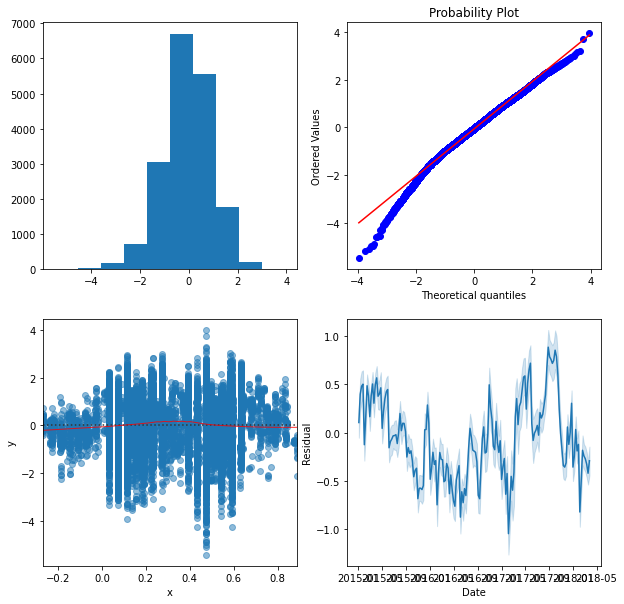

================================================== Test for Normality ==================================================


C:\Users\abddd\anaconda3\lib\site-packages\scipy\stats\morestats.py:1681: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


,test statistic,p-value
Jarque-Bera,822.210253,0.000000e+00
Kolmogorov-Smirnov,0.024275,8.960570e-10
Shapiro-Wilk,0.991664,5.806477e-31



======================================== Test for First Order AutoCorrelation ========================================


,test statistic,p-value
Breusch-Godfrey,335.828787,5.167765e-75


In [59]:
Model_Diagnostic(model = model, date = data['Date'], gp = X.columns.tolist())

# Conclusion

1. The model does not have lack of fit problem as the ratio is close to 1  
2. The average price of organic avocadoes is about 42.9\% (exp(0.3572)-1) higher than conventional avocadoes on average in the same region and same season. There are some regions having different average price odds (e.g. Houston and New York). There are also some seasons having different odds (Summer and Autumn)

# Problems

1. There are heteroscedasticity and serial correlation as the points in the middle value of predicted y are more widely spread and the time series plot shows a trendancy of negative autocorrelation. These violate the assumption of i.i.d which makes the confidence intervals less reliable.

# Further Work

1. Possible transformation:  
    1.1 We can see that the variance is not constant. Therefore, we can try Box-Cox transformation to stabilize the variance. However, it may suggest some meaningless transformation.   
2. Time series model:  
    2.1 As the average price and residuals are increasing from time, we can try to construct time series model so as to fit the pattern better (ARIMAX etc.).  
3. Random effect:  
    3.1 The regions seem to be randomly drawn and do not represent all the regions in US. We can fit a generalized linear mixed model to model the random effect.
4. Hypothesis testing on the final model:
    4.1 There are some effect having similar coefficients (e.g. DallasFtWorth and SouthCentral) in the final model. We can do some testing on if their effects are the same.